In [ ]:
# Install Kaggle CLI and upload kaggle.json
!pip install -q kaggle

from google.colab import files
files.upload()  # Upload your kaggle.json here


In [2]:
# Move kaggle.json to correct location
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

# **Dataset loading**

In [3]:
!mkdir -p ./datasets/{snow,rain,fog,normal}

### Snow Dataset

In [ ]:
# Clone GitHub repo for Snow-Roads Dataset
!git clone https://github.com/modraa-pixels/Snow-Covered-Roads-Dataset.git
!mv Snow-Covered-Roads-Dataset ./datasets/snow

### Rain Dataset

In [ ]:
# Download and unzip the Rainy dataset
!kaggle datasets download -d ducnt17/rainy-image-dataset
!unzip -q rainy-image-dataset.zip -d ./datasets/rain

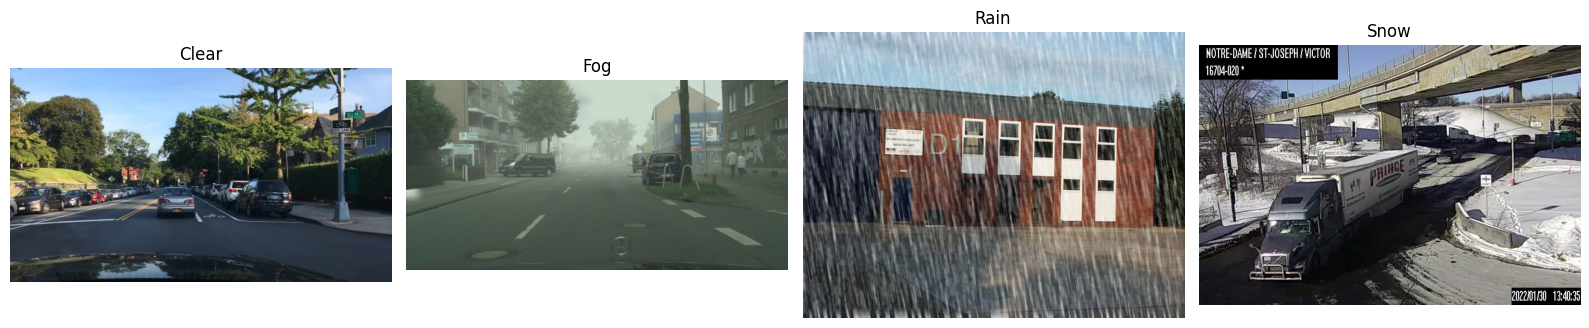

In [ ]:
# import os
# import random
# from PIL import Image
# import matplotlib.pyplot as plt

# # Define paths
# base_dir = './merged_weather_dataset'
# weather_classes = ['clear', 'fog', 'rain', 'snow']

# # Function to display one random image from each class
# def show_samples():
#     fig, axes = plt.subplots(1, 4, figsize=(16, 4))
#     for idx, category in enumerate(weather_classes):
#         category_path = os.path.join(base_dir, category)
#         all_images = [f for f in os.listdir(category_path) if f.lower().endswith(('.png', '.jpg', '.jpeg'))]

#         if not all_images:
#             print(f"No images found in {category_path}")
#             continue

#         random_image = random.choice(all_images)
#         img_path = os.path.join(category_path, random_image)
#         img = Image.open(img_path)

#         axes[idx].imshow(img)
#         axes[idx].set_title(category.capitalize())
#         axes[idx].axis('off')

#     plt.tight_layout()
#     plt.show()

# # Run the function
# show_samples()


# **CycelGAN model ---- fog**

In [ ]:
!mkdir -p ./FOG_weather_db/{trainA,trainB}

In [ ]:
rm -rf /content/FOG_weather_db/trainB

In [ ]:
# Move clear (no fog) to trainA
!mv /content/datasets/fog/Foggy_Cityscapes/No_Fog/* /content/FOG_weather_db/trainA

In [ ]:
import os
import shutil

# Paths
medium_fog_dir = "/content/datasets/fog/Foggy_Cityscapes/Medium_Fog"
dense_fog_dir = "/content/datasets/fog/Foggy_Cityscapes/Dense_Fog"
trainB_dir = "/content/FOG_weather_db/trainB"

# Ensure trainB directory exists
os.makedirs(trainB_dir, exist_ok=True)

# Move and rename medium fog images
for fname in os.listdir(medium_fog_dir):
    src_path = os.path.join(medium_fog_dir, fname)
    dst_path = os.path.join(trainB_dir, f"medium_{fname}")
    shutil.copy(src_path, dst_path)

# Move and rename dense fog images
for fname in os.listdir(dense_fog_dir):
    src_path = os.path.join(dense_fog_dir, fname)
    dst_path = os.path.join(trainB_dir, f"dense_{fname}")
    shutil.copy(src_path, dst_path)


In [ ]:
import os

image_extensions = ('.jpg', '.jpeg', '.png')

paths = {
    "trainA": '/content/FOG_weather_db/trainA',
    "trainB": '/content/FOG_weather_db/trainB',
}

total_images = 0

for name, folder_path in paths.items():
    count = sum(
        1 for file in os.listdir(folder_path)
        if file.lower().endswith(image_extensions)
    )
    total_images += count
    print(f"{name.capitalize()} folder: {count} images")

print(f"\nTotal images in FOG dataset: {total_images}")

Traina folder: 500 images
Trainb folder: 1000 images

Total images in FOG dataset: 1500


In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
%cd pytorch-CycleGAN-and-pix2pix
!pip install -r requirements.txt


Cloning into 'pytorch-CycleGAN-and-pix2pix'...
remote: Enumerating objects: 2521, done.
remote: Counting objects: 100% (3/3), done.
remote: Compressing objects: 100% (3/3), done.
remote: Total 2521 (delta 0), reused 0 (delta 0), pack-reused 2518 (from 1)
Receiving objects: 100% (2521/2521), 8.21 MiB | 34.58 MiB/s, done.
Resolving deltas: 100% (1576/1576), done.
/content/pytorch-CycleGAN-and-pix2pix
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.4/1.4 MB 38.4 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 69.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 36.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 50.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 2.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.3 MB/s eta 0:00:00

In [ ]:
from PIL import Image
import torchvision.transforms as T
import os

augment = T.Compose([
    T.RandomHorizontalFlip(),
    T.RandomRotation(10),
    T.ColorJitter(brightness=0.3, contrast=0.3, saturation=0.2),
    T.RandomResizedCrop(256, scale=(0.8, 1.0)),
])

input_dir = "/content/FOG_weather_db/trainA"
augmented_dir = "/content/FOG_weather_db/trainA"

image_files = os.listdir(input_dir)

for idx, fname in enumerate(image_files):
    path = os.path.join(input_dir, fname)
    img = Image.open(path).convert("RGB")

    for i in range(2):  # create 2 augmented versions
        new_img = augment(img)
        new_img.save(os.path.join(augmented_dir, f"aug_{idx}_{i}.jpg"))


In [ ]:
!bash /content/pytorch-CycleGAN-and-pix2pix/scripts/download_cyclegan_model.sh monet2photo

Note: available models are apple2orange, orange2apple, summer2winter_yosemite, winter2summer_yosemite, horse2zebra, zebra2horse, monet2photo, style_monet, style_cezanne, style_ukiyoe, style_vangogh, sat2map, map2sat, cityscapes_photo2label, cityscapes_label2photo, facades_photo2label, facades_label2photo, iphone2dslr_flower
Specified [monet2photo]
for details.

--2025-07-30 13:49:55--  http://efrosgans.eecs.berkeley.edu/cyclegan/pretrained_models/monet2photo.pth
Resolving efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)... 128.32.244.190
Connecting to efrosgans.eecs.berkeley.edu (efrosgans.eecs.berkeley.edu)|128.32.244.190|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 45575747 (43M)
Saving to: ‘./checkpoints/monet2photo_pretrained/latest_net_G.pth’

./checkpoints/monet 100%[===================>]  43.46M  14.0MB/s    in 3.4s    

2025-07-30 13:49:59 (12.7 MB/s) - ‘./checkpoints/monet2photo_pretrained/latest_net_G.pth’ saved [45575747/45575747]



In [ ]:
!mkdir -p checkpoints/clear2foggy

# Copy and rename it to match CycleGAN's expected format
!cp /content/pytorch-CycleGAN-and-pix2pix/checkpoints/monet2photo_pretrained/latest_net_G.pth \
     checkpoints/clear2foggy/latest_net_G_A.pth

In [ ]:
# Use the same weights for G_B (copy G_A → G_B)
!cp checkpoints/clear2foggy/latest_net_G_A.pth checkpoints/clear2foggy/latest_net_G_B.pth

In [ ]:
# using existing pth after first traning 50 epochs
!cp -r /content/drive/MyDrive/clear2foggy /content/pytorch-CycleGAN-and-pix2pix/checkpoints/

In [ ]:
# # updates train.py code



# import time
# from options.train_options import TrainOptions
# from data import create_dataset
# from models import create_model
# from util.visualizer import Visualizer

# # ✅ NEW: Add TensorBoard writer
# from torch.utils.tensorboard import SummaryWriter

# if __name__ == '__main__':
#     opt = TrainOptions().parse()   # get training options
#     dataset = create_dataset(opt)  # create a dataset given opt.dataset_mode and other options
#     dataset_size = len(dataset)    # get the number of images in the dataset.
#     print('The number of training images = %d' % dataset_size)

#     model = create_model(opt)      # create a model given opt.model and other options
#     model.setup(opt)               # regular setup: load and print networks; create schedulers
#     visualizer = Visualizer(opt)   # create a visualizer that display/save images and plots

#     # ✅ NEW: Initialize TensorBoard SummaryWriter
#     writer = SummaryWriter(log_dir=f'./runs/{opt.name}')

#     total_iters = 0                # the total number of training iterations

#     for epoch in range(opt.epoch_count, opt.n_epochs + opt.n_epochs_decay + 1):
#         epoch_start_time = time.time()
#         iter_data_time = time.time()
#         epoch_iter = 0
#         visualizer.reset()
#         model.update_learning_rate()

#         for i, data in enumerate(dataset):
#             iter_start_time = time.time()
#             if total_iters % opt.print_freq == 0:
#                 t_data = iter_start_time - iter_data_time

#             total_iters += opt.batch_size
#             epoch_iter += opt.batch_size
#             model.set_input(data)
#             model.optimize_parameters()

#             if total_iters % opt.display_freq == 0:
#                 save_result = total_iters % opt.update_html_freq == 0
#                 model.compute_visuals()
#                 visualizer.display_current_results(model.get_current_visuals(), epoch, save_result)

#             if total_iters % opt.print_freq == 0:
#                 losses = model.get_current_losses()
#                 t_comp = (time.time() - iter_start_time) / opt.batch_size
#                 visualizer.print_current_losses(epoch, epoch_iter, losses, t_comp, t_data)
#                 if opt.display_id > 0:
#                     visualizer.plot_current_losses(epoch, float(epoch_iter) / dataset_size, losses)

#                 # ✅ NEW: Log losses to TensorBoard
#                 for loss_name, loss_val in losses.items():
#                     writer.add_scalar(f'Loss/{loss_name}', loss_val, total_iters)

#             if total_iters % opt.save_latest_freq == 0:
#                 print('saving the latest model (epoch %d, total_iters %d)' % (epoch, total_iters))
#                 save_suffix = 'iter_%d' % total_iters if opt.save_by_iter else 'latest'
#                 model.save_networks(save_suffix)

#             iter_data_time = time.time()

#         if epoch % opt.save_epoch_freq == 0:
#             print('saving the model at the end of epoch %d, iters %d' % (epoch, total_iters))
#             model.save_networks('latest')
#             model.save_networks(epoch)

#         print('End of epoch %d / %d \t Time Taken: %d sec' %
#               (epoch, opt.n_epochs + opt.n_epochs_decay, time.time() - epoch_start_time))

#     # ✅ NEW: Close the writer at the end of training
#     writer.close()


In [ ]:
!python train.py \
  --dataroot /content/FOG_weather_db \
  --name clear2foggy \
  --model cycle_gan \
  --preprocess scale_width_and_crop \
  --load_size 286 \
  --crop_size 256 \
  --batch_size 1 \
  --n_epochs 50 \
  --n_epochs_decay 50


In [ ]:
!zip -r clear2foggy_checkpoint.zip /content/pytorch-CycleGAN-and-pix2pix/checkpoints/clear2foggy

In [ ]:
from google.colab import files
files.download('clear2foggy_checkpoint.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [11]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
!cp -r "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/clear2foggy" "/content/drive/MyDrive/Colab Notebooks/FYP/cycleGAN-weather"


# **CycleGAN model -- snow and rain**

In [7]:
!mkdir -p ./SNOW_weather_db/{trainA,trainB}

In [ ]:
!unzip "/content/drive/MyDrive/Colab Notebooks/FYP/DATASET/clear snow images /trainA.zip" -d "/content/SNOW_weather_db/"

In [18]:
import os
import shutil

# Paths
medium_snow_dir = "/content/datasets/snow/Snow-Covered-Roads-Dataset/dataset/train/medium"
light_snow_dir = "/content/datasets/snow/Snow-Covered-Roads-Dataset/dataset/train/light"
trainB_dir = "/content/SNOW_weather_db/trainB"

# Ensure trainB directory exists
os.makedirs(trainB_dir, exist_ok=True)

# Move and rename medium fog images
for fname in os.listdir(medium_snow_dir):
    src_path = os.path.join(medium_snow_dir, fname)
    dst_path = os.path.join(trainB_dir, f"medium_{fname}")
    shutil.copy(src_path, dst_path)

# Move and rename dense fog images
for fname in os.listdir(light_snow_dir):
    src_path = os.path.join(light_snow_dir, fname)
    dst_path = os.path.join(trainB_dir, f"light_{fname}")
    shutil.copy(src_path, dst_path)


In [19]:
import os

image_extensions = ('.jpg', '.jpeg', '.png')

paths = {
    "trainA": '/content/SNOW_weather_db/trainA',
    "trainB": '/content/SNOW_weather_db/trainB',
}

total_images = 0

for name, folder_path in paths.items():
    count = sum(
        1 for file in os.listdir(folder_path)
        if file.lower().endswith(image_extensions)
    )
    total_images += count
    print(f"{name.capitalize()} folder: {count} images")

print(f"\nTotal images in SNOW dataset: {total_images}")

Traina folder: 15185 images
Trainb folder: 15185 images

Total images in SNOW dataset: 30370


In [ ]:
!git clone https://github.com/junyanz/pytorch-CycleGAN-and-pix2pix
%cd pytorch-CycleGAN-and-pix2pix
# !pip install -r requirements.txt

In [ ]:
!pip install numpy==1.24.3 scikit-image Pillow>=10.0.0 dominate>=2.8.0 wandb>=0.16.0
!pip install torch==2.4.0 torchvision==0.19.0 --index-url https://download.pytorch.org/whl/cu121


In [ ]:
!bash /content/pytorch-CycleGAN-and-pix2pix/scripts/download_cyclegan_model.sh monet2photo

In [20]:
!mkdir -p checkpoints/clear2snowy

# Copy and rename it to match CycleGAN's expected format
!cp /content/pytorch-CycleGAN-and-pix2pix/checkpoints/monet2photo_pretrained/latest_net_G.pth \
     checkpoints/clear2snowy/latest_net_G_A.pth

In [21]:
# Use the same weights for G_B (copy G_A → G_B)
!cp checkpoints/clear2snowy/latest_net_G_A.pth checkpoints/clear2snowy/latest_net_G_B.pth

In [ ]:
# using existing pth after first traning 50 epochs
!cp -r /content/drive/MyDrive/clear2snowy /content/pytorch-CycleGAN-and-pix2pix/checkpoints/

In [ ]:
!python train.py \
  --dataroot /content/SNOW_weather_db \
  --name clear2snowy \
  --model cycle_gan \
  --preprocess scale_width_and_crop \
  --load_size 286 \
  --crop_size 256 \
  --batch_size 1 \
  --n_epochs 5 \
  --n_epochs_decay 5 \
  --max_dataset_size 300


In [ ]:
!zip -r clear2snowy_checkpoint.zip /content/pytorch-CycleGAN-and-pix2pix/checkpoints/clear2snowy

In [32]:
from google.colab import files
files.download('clear2snowy_checkpoint.zip')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [33]:
!cp -r "/content/pytorch-CycleGAN-and-pix2pix/checkpoints/clear2snowy" "/content/drive/MyDrive/Colab Notebooks/FYP/cycleGAN-SNOW-weather"

In [37]:
!mkdir -p /content/input_img

In [ ]:
!python /content/pytorch-CycleGAN-and-pix2pix/test.py \
  --dataroot /content/input_img \
  --name clear2snowy \
  --model test \
  --model_suffix _A \
  --no_dropout \
  --preprocess scale_width_and_crop \
  --load_size 286 \
  --crop_size 256 \
  --netG resnet_9blocks \
  --direction AtoB \
  --results_dir /content/snow_results \
  --checkpoints_dir /content/pytorch-CycleGAN-and-pix2pix/checkpoints


In [ ]:
import IPython.display as display
from PIL import Image
import glob

output_images = sorted(glob.glob('/content/snow_results/clear2snowy/test_latest/images/clear day_fake.png'))
for img_path in output_images:
    display.display(Image.open(img_path))